In [1]:
#hidden cell to be executed BEFORE the presentation
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import dftpy
from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional
from dftpy.formats import io
from dftpy.math_utils import ecut2nr
from dftpy.time_data import TimeData
from dftpy.optimization import Optimization
from dftpy.mpi import sprint
from IPython.lib.display import YouTubeVideo
from IPython.display import IFrame
from ase.visualize import view
PP_list = {'Al': 'Al_lda.oe01.recpot'}
#import fortecubeview

<center>
    <h1>DFT and DFT embedding</h1>
    <h3> Ways to approach the mesoscopic world with ab-initio methods (without cutting corners)</h3>
<center>
<br>
<table>
  <tr>
      <td><p><h1>Michele Pavanello</h1></p><p><h2>Rutgers University-Newark</h2></p></td>
      <td><img src="figures/logos/run.png" width=200 height=200 /></td>
  </tr>
  <tr>
    <td></td>
    <td> http://prg.rutgers.edu</td>
  </tr>
</table>

#### ASESMA School -- June 22, 2023


# Ready to work?

<div class="alert alert-block alert-success">
    <center><b>Find this Jupyter Notebook at ~/ASESMA2023/PROJECTS/Pavanello</b></center>
    </div>

# Acknowledgements

<table>
  <tr>
      <td><p><h3>Students</h3></p><p>Dr Xuecheng Shao</p><p>Dr Xin Chen</p><p>Alina Umerbekova</p><p>Jessica Martinez</p><p>Valeria Rios </p><p>Nick Viot</p></td>
      <td><img src="figures/prg_pics/prg_2023.png" width=800 /></td>
  </tr>
</table>

Funding: NSF, DOE, MolSSI, ACS-PRF, Rutgers

# The Real World
<table>
    <tr>
      <td><h3>Photocatalyst</h3></td>
        <td><h3>Catalytic nanoparticles</h3></td>
  </tr>
  <tr>
      <td><img src="figures/science/photocatalyst.png" height=500 /></td>
      <td><img src="figures/science/catalyst.png" height=500 /></td>
  </tr>
    <tr>
        <td>Chem. Comm., 43, 6551 (2009)</td>
        <td>PCCP, 21, 15080 (2019)</td>
    </tr>
</table>   

# Available electronic structure methods
<br>
<center>
    <img src="figures/science/electronic_structure.png" width=1600 />
</center>

# The energy functional, $E[n]$

The energy functional is a functional of the many-body wavefunction:
$$
E[\Psi]=T[\Psi]+W_{ee}[\Psi]+\int n(\mathbf{r}) v_{ext}(\mathbf{r}) d \mathbf{r},
$$
where the electron density is given by:
$$
n(\mathbf{r}) = N \int |\Psi(\mathbf{r},\mathbf{r}_2,\ldots \mathbf{r}_N)|^2 d\mathbf{r}_2\ldots d\mathbf{r}_N.
$$

...but as you have seen last week, the Hohemberg and Kohn theorems allow us to write the same energy as a functional of the density alone:

$$E[n]=T_s[n]+ E_H[n]+E_{xc}[n]+\int n(\mathbf{r}) v_{ext}(\mathbf{r}) d \mathbf{r}$$

# The KS system

The KS system is a ficticious system of non-interacting electrons. The wavefunction is given as an antisymmetrized (must satisfy Pauli principle!) product of one-electron wavefunction or <b>KS orbitals</b>.

The KS orbitals give us the 

# Non-interacting kinetic energy

The non-interacting kinetic energy is a crucial quantity in DFT:
$$T_s[n] = \sum_i \omega_i \int \phi_i(\mathbf{r})\nabla^2\phi_i(\mathbf{r}) d \mathbf{r}$$
where $\omega_i$ are the `occupation numbers`.

Note: it is <b>not</b> the true kinetic energy, but it allows us to define the KS equations, which give us the KS orbitals which give us the density which give us the energy!

The KS equations are:
$$
-\frac{1}{2}\nabla^2 \phi_i(\mathbf{r}) + v_s(\mathbf{r}) \phi_i(\mathbf{r}) = \varepsilon_i \phi_i(\mathbf{r})
$$

# We have a nice chain of events:

<br>
<div class="alert alert-block alert-success">$$
\text{KS equations} \to \{\phi_i\} \to n(\mathbf{r}) \to E[n], \text{forces} \ldots
$$</div>

where 

$$E[n]=T_s[n]+ E_H[n]+E_{xc}[n]+\int n(\mathbf{r}) v_{ext}(\mathbf{r}) d \mathbf{r}$$

<div class="alert alert-block alert-warning"><center>Note $E_{xc}[n]$, the exchange-correlation functional</center></div>

# What is the `cost` of getting the KS orbitals?

 - Must solve KS equations

How expensive is that? Any guesses?

<div class="alert alert-block alert-success"><center>Like solving an eigenvalue problem</center></div>

<div class="alert alert-block alert-warning"><center>Like diagonalizing a matrix</center></div>

<div class="alert alert-block alert-danger"><center>Oh, no! Bad news, it is like $\mathcal{O}(N^3)$!</center></div>

# Why is it `bad news`?

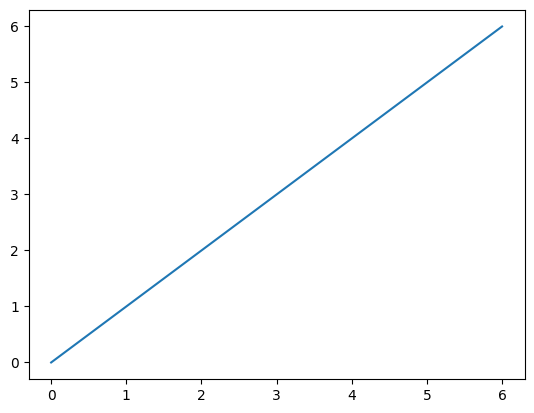

In [6]:
import matplotlib.pyplot as plt
x=np.array([0,1,2,3,4,5,6])
y=x**1
plt.plot(x,y)

<div class="alert alert-block alert-danger"><center>We need alternative methods if we wish to approach <i>realistic</i> systems</center></div>

# An option: Orbital-free DFT (OF-DFT)
<br>

<center>
<ul>
    <li><p>The variational function is the electron density <u>only</u></p> 
        <p>$$n(\mathbf{r})=N |\psi(\mathbf{r})|^2$$</p></li>
    <li><p>The energy functional is a <b>pure</b> functional of $n(\mathbf{r})$</p>
        <p>$$E[n]=T_s[n]+ E_H[n]+E_{xc}[n]+\int n(\mathbf{r}) v_{ext}(\mathbf{r}) d \mathbf{r} $$</p></li>
    <li><p>Ground state is found by direct minimization</p>
        <p>$$n_0(\mathbf{r})=\text{arg}\min_n\left[ E[n]-\mu \left(\int n(\mathbf{r})d\mathbf{r}-N\right)\right]$$</p></li>
</ul>
</center>
<div class="alert alert-block alert-success"><center><b>Opportunities:</b> (1) No need to diagonalize any matrix! (2) Complexity $\mathcal{O}[N\ln N]$</center></div>
<div class="alert alert-block alert-danger"><center><b>Problem:</b> $T_s[n]$ exists, but it is not known...</center></div>

# Orbital-free vs Kohn-Sham DFT
<br>
<ul>
    <li><p>KS and OF energy functionals are the same</p>
        <p>$$E[n]=T_s[n]+\int n(\mathbf{r}) v_{ext}(\mathbf{r}) d \mathbf{r} + E_{xc}[n]+ E_{H}[n]$$</p></li>
    <li><p><b>In practice</b>, the noninteracting kinetic energy is treated differently</p>
        <p>$$T_s[n]~\mathrm{vs}~T_s[\{\psi_i[n]\}$$</p></li>
</ul>
</center>

### $T_s[n]$ a long history$\ldots$
<br>
<center>
    <img src="figures/science/ofdft_table.png" width=650 />
    </center>

### $T_s[n]$ options: (semi)local and nonlocal functionals
<br>
<center>
    <img src="figures/science/local_nonlocal.png" width=1600 />
<p>Wenhui Mi, MP JCP (2018) • Wenhui Mi, MP PRB (2019) • Xuecheng Shao, WM, MP PRB (2021)
Xuecheng Shao, WM, MP JPCL (2021) • Xuecheng Shao, WM, MP JCTC (2021) • Wenhui Mi, MP JPCL (2020)</p>
    </center>

# How hard is it to run OF-DFT simulations?

### First generate a model system: bulk Al (cubic cell)

In [7]:
from ase.build import bulk
atoms = bulk('Al', 'fcc', a=4.05, cubic=True)
ions = Ions.from_ase(atoms)
view(ions, viewer='ngl')

### Then run a OF-DFT simulation with `DFTpy`

In [3]:
IFrame('http://dftpy.rutgers.edu', width=800, height=300)

In [4]:
nr = ecut2nr(ecut=35, lattice=ions.cell)
nr

array([20, 20, 20], dtype=int32)

In [5]:
grid = DirectGrid(lattice=ions.cell, nr=nr)
PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list)
rho_ini = DirectField(grid=grid)
rho_ini[:] = ions.get_ncharges()/ions.cell.volume
HARTREE = Functional(type='HARTREE')
XC = Functional(type='XC',name='LDA')

setting key: Al -> Al_lda.oe01.recpot


### Let's pick a $T_s[n]$

- $T_s[n]$ also called KEDF. In this example we use Thomas Fermi + von Weizsacker:
$$T_s[n] = \int C_{TF} n^{5/3}(\mathbf{r}) + \frac{\nabla n^{1/2}(\mathbf{r})\cdot \nabla n^{1/2}(\mathbf{r})}{2} d\mathbf{r}$$

In [6]:
KE = Functional(type='KEDF',name='x_TF_y_vW') 

### Define "total energy" and minimize $E[n]$

In [7]:
evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
optimization_option s = {'econv' : 1e-6*ions.nat}
opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options,
        optimization_method = 'TN')
%timeit -n1 -r1 rho = opt.optimize_rho(guess_rho=rho_ini)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.692153511701E+00      2.692154E+00    7.877088E-01    1       1       1.300406E-02    
1       2.509905170260E+00      -1.822483E-01   7.033208E-02    2       1       2.418685E-02    
2       2.502273082057E+00      -7.632088E-03   4.803551E-03    7       1       4.769683E-02    
3       2.502030159489E+00      -2.429226E-04   3.640546E-04    5       1       6.959200E-02    
4       2.501995243580E+00      -3.491591E-05   3.590712E-05    6       1       9.144711E-02    
5       2.501992596736E+00      -2.646845E-06   2.500920E-06    5       1       1.122010E-01    
6       2.501992226204E+00      -3.705314E-07   4.568870E-08    8       1       1.391349E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.30115196527266436
Chemical potential (eV)  : 8.194761597103438
141 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<div class="alert alert-block alert-success"><center><b>Opportunities:</b> Can manipulate rho as you wish - many functionalities are available in DFTpy</center></div>

...let's try to re-run it with a different $T_s[n]$.

### Re-run of OF-DFT with nonlocal $T_s[n]$

In [8]:
KE = Functional(type='KEDF',name='WT')
evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
optimization_options = {'econv' : 1e-5*ions.nat}
opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options,
        optimization_method = 'TN')
%timeit -n1 -r2 rho = opt.optimize_rho(guess_rho=rho_ini)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.692153511701E+00      2.692154E+00    7.877088E-01    1       1       5.927086E-03    
1       2.444924565114E+00      -2.472289E-01   5.654301E-02    7       1       4.430294E-02    
2       2.440061475872E+00      -4.863089E-03   3.268387E-03    7       1       7.767415E-02    
3       2.439474424121E+00      -5.870518E-04   3.047555E-04    9       1       1.174870E-01    
4       2.439456503674E+00      -1.792045E-05   2.723036E-05    5       1       1.434309E-01    
5       2.439454396546E+00      -2.107128E-06   1.881566E-06    7       1       1.763270E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.2927374982051514
Chemical potential (eV)  : 7.9657923073878125
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.692153511701E+00      2.692154E+00    7.877088E-01    1       1       5.973101E-0

<center><div class="alert alert-block alert-danger">
    Nonlocal $T_s[n]$ are somewhat slower than semilocal functionals
</div> 
    </center>

# How does OF-DFT compare with KS-DFT?

<h4 style="text-align: center;">We will run a Quantum ESPRESSO calculation of the same system using QEpy</h4>

In [9]:
from qepy.driver import Driver
from qepy.io import QEInput

In [10]:
IFrame('http://qepy.rutgers.edu', width=1000, height=400)

### QEpy's input file is a dictionary

In [11]:
qe_options = {
    '&control': {
        'calculation': "'scf'",
        'pseudo_dir': "'./'",
    },
    '&system': {
        'ibrav' : 0,
        'degauss': 0.005,
        'ecutwfc': 30,
        'occupations': "'smearing'"
    },
    'atomic_species': ['Al  26.98 Al.pbe-nl-kjpaw_psl.1.0.0.UPF'],
    'k_points gamma': [],
}

!wget http://pseudopotentials.quantum-espresso.org/upf_files/Al.pbe-nl-kjpaw_psl.1.0.0.UPF

In [12]:
options = {
    '&electrons': {
        'mixing_beta': 0.5},
    'cell_parameters angstrom':[
        '0.     2.025  2.025',
        '2.025  0.     2.025',
        '2.025  2.025  0.   '],
    'atomic_positions crystal': ['Al    0.0  0.0  0.0'],
    'k_points automatic': ['11 11 11 1 1 1'],
}

### Initialize QEpy

In [13]:
qe_options = QEInput.update_options(options, qe_options=qe_options)

In [14]:
driver = Driver(qe_options=qe_options, logfile=True)
%timeit -n1 -r1 driver.scf() 

9.26 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [15]:
driver.get_scf_error()

8.733828545097041e-08

In [16]:
driver.stop()

<center><div class="alert alert-block alert-danger">
    KS-DFT is $\bigstar$ times slower than nonlocal OF-DFT for this small system.
</div></center>

# Poll time
- People say OF-DFT is a "linear-scaling method". Do you agree?

<div class="alert alert-block alert-success">
<b>A:</b> Yep! I do!</div>

<div class="alert alert-block alert-danger">
<b>B:</b> Nah. Not really.</div>

<div class="alert alert-block alert-warning">
<b>C:</b> Sometimes.</div>

# Can OF-DFT approach surfaces?

<center>
    <p style="font-size:100%; text-align:center;">Shao, Mi & Pavanello, Phys. Rev. B <b>104</b>, 045118 (2021)</p>
    <br>
    <img src="figures/science/ofdft_surfaces.png" width=1800 />
    <div class="alert alert-block alert-success">Excellent results for difficult semiconductors and metals!</div>
</center>

# What else can OF-DFT do?
<br>
<center>
    <p style="font-size:100%; text-align:center;"> J. Phys. Chem. Lett. <b>12</b>, 4134 (2021) &#x25C6; WIREs: Comp. Mol. Sci. <b>11</b>, e1482 (2021)</p>
    <br>
    <img src="figures/science/ofdft_showoff.png" width=1600 />
    <div class="alert alert-block alert-danger">How about optical spectra and dynamics?</div>
</center>

# OF-DFT is limited...
<br>
<center>
<img src="figures/science/periodic_all.png" width=1100 />
</center>

# OF-DFT is limited$\ldots$ but why?
<br>
<center>
<img src="figures/science/periodic_ofdft.png" width=1100 />
</center>

<h1> What are nonlocal PPs?</h1>

<br>
<div class="split left">
    <div class="centered">
    <h2>Core Electrons</h2>
        <br>
        <br>
        <br>
    <img src="figures/random/p_orbital.jpeg" width=400 />
    <p>Using pseudo-potentials, core electrons are "hidden"</p>
    </div>
</div>

<div class="split right">
    <div class="centered">
    <h2>Valence Electrons</h2>
    <p>Need to be orthogonal to the core electrons</p>
    <img src="figures/random/gs_rth.svg" width=400 />
    <p>The Gram-Schmidt orthogonalization is a good example</p>
    </div>
</div>



<h2>Non-local pseudo-potentials explained</h2>

Apply Gram-Schmidt to the set of valence, $|\phi\rangle$, and core, $|\text{core}\rangle$, electrons:
$$
|\phi\rangle \to |\phi\rangle - |\text{core}\rangle\langle\text{core}|\phi\rangle = \bigg[ 1 - |\text{core}\rangle\langle\text{core}| \bigg] |\phi\rangle 
$$

<center>
<div class="alert alert-success alert-warning">$\hat{P}_{nl}=\bigg[ 1 - |\text{core}\rangle\langle\text{core}| \bigg]$ is the <b>non-local pseudopotential</b></div>
</center>

<center>
<div class="alert alert-block alert-danger">In OF-DFT $|\phi\rangle$ is not available$\ldots$</div>
</center>

# Poll time / challenge
- How would you fix OF-DFT's impossibility to use nonlocal PPs?

<div class="alert alert-block alert-warning">
<b>A:</b> Use KS-DFT for atoms only, or smaller fragments of the system..and then combine them together with OF-DFT</div>

<div class="alert alert-block alert-warning">
<b>B:</b> Throw OF-DFT away!</div>

<div class="alert alert-block alert-warning">
<b>C:</b> Introduce nonlocal pseudopotentials in OF-DFT somehow</div>

# Subsystem DFT (sDFT) - Theory

<div class="alert alert-block alert-warning">
    <p><b>Idea:</b></p>
    <ul>
        <li>Split system into (smaller) subsystems: $n(\mathbf{r})=\sum_I n_I(\mathbf{r})$</li>
        <li>Use KS-DFT <b>or</b> OF-DFT for the subsystems</li>
        <li><p>Energy is split in <i>additive</i> and <i>non-additive</i> terms:</p><p>$$E[n]\equiv E[\{n_I\}]=\sum_I E[n_I] + E^{nadd}[\{n_I\}]$$</p></li>
        <li><p>The nonadditive energy given by:</p><p>$$E^{nadd}[\{n_I\}] = E_{Coul}[n] - \sum_IE_{Coul}[n_I] +  E_{xc}[n] - \sum_IE_{xc}[n_I] + T_{s}[n] - \sum_IT_{s}[n_I]$$</p></li>
    </ul>
</div>
<div class="alert alert-block alert-danger">
<b>Problem:</b> The non-additive energy contains the non-additive kinetic energy, $T_s^{nadd}[\{n_I\}]$, which not known.
</div>
<div class="alert alert-block alert-success">
    <b>Opportunity:</b> We can use <i>fancy non-local</i> $T_s^{nadd}[\{n_I\}]$, previously developed for OF-DFT.
</div>

# sDFT implementations
<br>
<br>
<br>

<div class="alert alert-block alert-success">
Our codes:
<table>
    <tr>
        <td>eQE</td><td>eDFTpy</td>
    </tr>
    <tr>
        <td>2017-2022</td><td>2022-present</td>
    </tr>
</table>
</div>
<br>
<br>
<br>

<div class="alert alert-block alert-warning">
The competition:
<table>
    <tr>
        <td>Serenity</td><td>CP2k</td>
    </tr>
     <tr>
        <td>Neugebauer (Münster)</td><td>Luber, Hutter (Zurich)</td>
    </tr>
</table>
</div>

# Want to learn more about `eDFTpy`?

In [17]:
IFrame('http://edftpy.rutgers.edu', width=1000, height=400)

# Subsystem DFT (sDFT) - Timings
<br>
<center>
<img src="figures/science/sdft_timings.png" width=1300 />
</center>
<ul>
    <li> Comp. Phys. Comm. <b>269</b>, 108122 (2021)</li>
    <li> Int. J. Quantum Chem. <b>117</b> e25401 (2017)</li>
    <li> J. Phys. Chem. Lett. <b>10</b> 7554 (2019)</li>
</ul>


# How accurate is sDFT?
<br>

<p style="font-size:100%; text-align:center;">Deviation against CCSD(T) for the S66 test set</p>

<table>
    <tr>
        <td>
            <center>
                <img src="figures/science/sdft_s66.png" width=700 />
            </center>
        </td>
        <td>&nbsp;&nbsp;&nbsp;&nbsp;</td>
        <td>
            <center>
                <img src="figures/science/S66_comparisons.png" width=700 />
            </center>
        </td>
    </tr>
    <tr>
        <td>
            <ul>
                <li> Comp. Phys. Comm. <b>269</b>, 108122 (2021)</li>
                <li> J. Chem. Theory Comput. <b>17</b> 3455 (2021)</li>
                <li> J. Phys. Chem. Lett. <b>11</b> 272 (2020)</li>
            </ul>
        </td>
        <td>
        </td>
        <td>
            <ul>
                <li> J. Chem. Theory Comput. <b>7</b> 2427 (2011)</li>
            </ul>
        </td>
    </tr>
    </tr>
</table>


<center><h3>sDFT success stories</h3></center>


<table>
    <tr>
        <td><h2>Liquid water</h2></td> <td><h2>Fluid CO<sub>2</sub></h2></td>
    </tr>
    <tr>
        <td><img src="figures/science/water_goo_w64.png" width=750 /></td><td><img src="figures/science/co2_gofr.png" width=600 /></td>
    </tr>
</table>
<center><div class="alert alert-block alert-success">
    Structure and dynamics recovered!
</div></center>

# sDFT is not perfect either...
<p>The nonadditive kinetic energy, $T_s^{nadd}[n]$, is not accurate enough when...</p>
<br>
<table>
    <tr>
    <td> &#x25C6; ...there are covalent bonds between subsystems</td>
        <td>&nbsp;&nbsp;&nbsp;&nbsp;</td>
    <td> &#x25C6; ...subsystems are too close</td>
    </tr>
</table>
<br>
<center>
    <img src="figures/science/diels_alder.png" width=950 />
    <div class="alert alert-block alert-success">
    Adaptive sDFT has only 1 parameter (rcut) related to the covalent radii.
</div>
</center>



# Adaptive sDFT

<br>

#### To do:

<ul style="text-align: left; font-size: 70%; line-height:90%;margin-top: 0; margin-bottom: 0;">
    <li>Must be able to "split" and "merge" subsystems along a dynamics</li>
    <li>Do so <i>automatically</i></li>
</ul>

<br>
<br>

<h4 style="margin-top: 0.5em;"> We did it... but it was challenging</h4>
<table>
    <tr>
        <td>
            <center>
            <ul style="border:2px solid red; text-align: left; font-size: 135%; line-height:150%; margin-right: 1em;">
                <li>Adaptive computational settings</li>
                <li>Adaptive MPI communicators</li>
                <li>Adaptive data allocation</li>
            </ul>
            </center>
        </td>
        <td style="width:55%">
            <img src="figures/science/sdft_merging_cells.png" width=100% />
        </td>
    </tr>
</table>

# Adaptive sDFT: dissociation of NaCl in water

https://www.youtube.com/watch?v=-lmdPHzJfeU

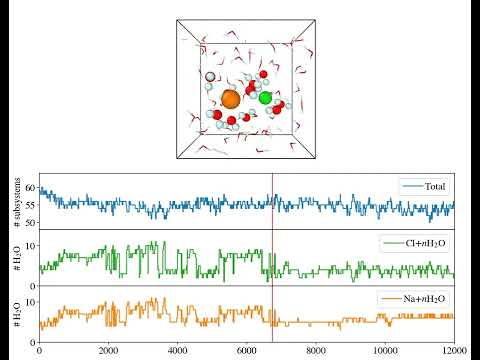

In [18]:
YouTubeVideo('-lmdPHzJfeU', width=600, height=450)

# Adaptive sDFT: hydration of Ni$^{2+}$, Pd$^{2+}$ and Pt$^{2+}$

<center>
    <table>
        <tr><td><b>Square Planar</b></td><td><b>Octahedral</b></td></tr>
        <tr><td><img src="./figures/science/Square-planar-3D-balls.png" width=450 /></td><td><img src="./figures/science/Octahedral-3D-balls.png" width=450 /></td></tr>
    </table>
</center>
<div class="alert alert-block alert-success">
    Stay tuned for an upcoming paper!
</div>

# Comparison with experiments for Ni and Pd

<br>
<center>
<table>
    <tr>
        <td><b><center>Ni(II) -- Total $G_{Ni}(r)$ and partial $G_{Ni-O}(r)$</center></b></td>
        <td><b><center>Pd(II) -- Total structure factor $S(Q)$</center></b></td>
    </tr>
    <tr>
        <td>
            <img src="figures/science/gofr_ni.png" width=850 align="center" />
        </td>
        <td>
            <img src="figures/science/SQ_pd.png" width=1150 align="center" />
        </td>
    </tr>
    <tr>
        <td>
            <ul>
            <li style="color:grey;">Almost quantitative agreement with experiments</li>
            <li>XRay: Powell et al 1989 J. Phys.: Condens. Matter 1 8721; </li>
            <li>N scattering: Nelson et al J. Phys. C 11, 15 L625 (1978)</li>
            </ul>
        </td>
        <td>
            <ul>
            <li style="color:blue;">Better agreement with the experiment compared with the EPSR result of Bowron <i>et al.</i></li>
            </ul>
        </td>
    </tr>
</table>
    </center>

# Despite the speaker, you learned:

<hr>
<div class="alert alert-block alert-success">
    <b>Good things:</b><br>
    <ul>
        <li> OF-DFT is very fast and linear scaling with system size</li>
        <li> OF-DFT is useful for metals and semiconductors of any shape and size</li>
        <li> Where OF-DFT fails we can use Subsystem DFT. Still linear scaling, and applicable to any inter-subsystem interaction strength</li>
        <li> Therefore, the applicability of KS-DFT is extended to larger, more meaningful systems</li>
    </ul>
</div>

<hr>

<div class="alert alert-block alert-danger">
<b>Bad things:</b><br>
    <ul>
        <li> OF-DFT has limited applicability because of the "nonlocal pseudopotential problem"</li>
        <li> Subsystem DFT is fast but only if subsystems are small</li>
    </ul>
</div>
<hr>

# Thank you!